In [1]:
import pennylane as qml
import numpy as np
from matplotlib import pyplot as plt
from pennylane import qaoa as qaoa
import networkx as nx

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


# Feedback-Based Quantum Optimization (FALQON)

By: David Wakeham and Jack Ceroni

In this demo, we'll be implement the FALQON algorithm, standing for *Feedback-based ALgorithm for Quantum Optimization*, introduced by [Magann, Rudinger, Grace & Sarovar (2021)](https://arxiv.org/pdf/2103.08619.pdf). It is similar in spirit to the [QAOA](https://arxiv.org/pdf/1411.4028.pdf), but scales with resources differently, using iterative feedback steps rather than a global optimization over parameters. We will show how to implement FALQON in PennyLane and test its performance on the **MaxClique** problem in graph theory!

### Theory

To solve combinatorial optimization problems using a quantum computer, a typical strategy is to encode the solution to the problem as the ground state of *cost Hamiltonian* $H_C$, and choose some strategy to drive the system from a known initial state into this ground state. FALQON falls under this broad scheme.

Imagine a quantum system governed by a Hamiltonian of the form $H = H_C + \beta(t) H_D$. These kinds of Hamiltonians come up quite often in the theory of [quantum control](https://quantiki.org/wiki/quantum-control-theory), which studies how we may go about driving a quantum system from one state to another. The choice of $\beta(t)$ allows us to decide which state we want a system governed by such a Hamiltonian to evolve towards. 

The time-dependent Schrodinger equation tells us that the dynamics of the system are given by:

$$
i \frac{d}{dt} |\psi(t)\rangle = (H_C + \beta(t) H_D) |\psi(t)\rangle,
$$

where we set $\hbar = 1$. Now, let us suppose that the objective of our quantum control experiment is to drive our system to the state $|\psi\rangle$: the ground state of $H_C$. Phrased differently, we would like to minimize the expectation value of $\langle H_C\rangle$ (an immediate consequence of the variational principle). Therefore, a reasonable goal is to construct our system such that the expectation decreases with time:

$$
\frac{d}{dt} \langle H_C\rangle_t = \frac{d}{dt} \langle \psi(t)|H_C|\psi(t)\rangle = i \beta(t)\langle [H_D, H_C] \rangle_t \leq 0,
$$

where we used the product rule and Schrödinger's equation. Recall that our control experiment depends on the choice of $\beta(t)$. Thus, if we pick $\beta(t) = -\langle i[H_D, H_C] \rangle_t$, so that

$$
\frac{d}{dt} \langle H_C\rangle_t = -|\langle i[H_D, H_C] \rangle_t|^2 \leq 0.
$$

then $\langle H_C \rangle$ is guaranteed to strictly decrease, as desired!

(Note that we bring the $i$ into the expectation to give a Hermitian operator.)
Using [techniques from control theory](https://arxiv.org/pdf/1304.3997.pdf), it is possible to rigorously show this will eventually drive the system into the ground state! Thus, if we evolve some initial state $|\psi_0\rangle$ under the time-evolution operator corresponding to $H$, given by $U(t) = e^{-iHt}$, then we will arrive at the ground state of $H$! We can approximately discretize $U$ using a Trotter-Suzuki decomposition, so we may implement it on a quantum circuit:

$$
U(t) \approx U_D(\beta_\ell) U_C U_D(\beta_{\ell-1}) U_C\cdots
U_D(\beta_1) U_C, \quad U_C = e^{-iH_C \Delta t}, \quad U_D(\beta_k) =
e^{-i\beta_k H_D \Delta t},
$$

where $\Delta t = t/2\ell$ and $\beta_k = \beta(2k\Delta t)$. One issue remains: for each step, we need to know the value $\beta_k$, which are themselves dependent on the state of the system, at some time. Our strategy is to use the value of $A(t) := i\langle [H_D, H_C] \rangle_t$ obtained by evaluating the circuit for the previous time-step:

$$
\beta_{k+1} = -A_k = -A(2k\Delta t).
$$

This leads immediately to the FALQON algorithm. On step $k$, we perform the following three substeps:

1. Prepare the state $|\psi_k\rangle = U_D(\beta_k) U_C \cdots U_D(\beta_1) U_C|\psi_0\rangle$,
2. Measure the expectation value $A_k = \langle i[H_C, H_D]\rangle_k$.
3. Set $\beta_{k+1} = -A_k$.

### Solving the MaxClique Problem with FALQON

Our goal is to solve the maximum clique (MaxClique) problem: finding the largest complete subgraph of a graph $G$. We begin by defining the graph on which we will perform MaxClique. We will use a graph of the form:

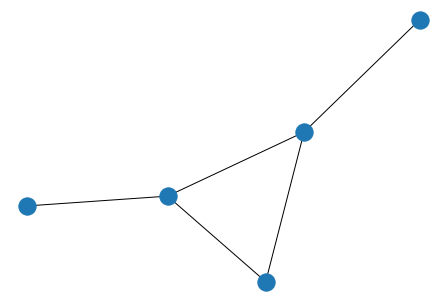

In [109]:
edges = [(0, 1), (1, 2), (2, 0), (2, 3), (1, 4)]
graph = nx.Graph(edges)
nx.draw(graph)

Recall that the cost Hamiltonian corresponding to the MaxClique problem is given by:

$$H_C = 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i$$

where $\bar{G}$ is the [complement](https://en.wikipedia.org/wiki/Complement_graph) of the graph $G$. As for $H_D$, we simply must choose a Hamiltonian that does not commute with $H_C$, and effectively "mixes" the state of the system as it is driven towards the desired state. Thus, we choose a simple sum of Pauli-X operations:

$$H_{D} = \displaystyle\sum_{i \in V(G)} X_i$$

We can generate these Hamiltonians easily, using PennyLane QAOA:

In [110]:
cost_h, driver_h = qaoa.max_clique(graph, constrained=False)

print("Cost Hamiltonian")
print(cost_h)
print("Driver Hamiltonian")
print(driver_h)

Cost Hamiltonian
  (-1.25) [Z3]
+ (-1.25) [Z4]
+ (-0.5) [Z0]
+ (0.25) [Z1]
+ (0.25) [Z2]
+ (0.75) [Z0 Z3]
+ (0.75) [Z0 Z4]
+ (0.75) [Z1 Z3]
+ (0.75) [Z2 Z4]
+ (0.75) [Z3 Z4]
Driver Hamiltonian
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


As you may recall, one of the main ingredients in the FALQON algorithm is the commutator $[H_D, H_C]$. In the case of MaxClique, we can write down the commutator explicitly, exploiting the bilinearity of the commutator:

$$[H_D, H_C] = \Big[ \displaystyle\sum_{i \in V(G)} X_i, 3 \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) + \displaystyle\sum_{i \in V(G)} Z_i \Big] = 3 \Big[ \displaystyle\sum_{i \in V(G)} X_i, \sum_{(i, j) \in E(\bar{G})} (Z_i Z_j - Z_i - Z_j) \Big] + 3 \Big[ \displaystyle\sum_{i \in V(G)} X_i, \displaystyle\sum_{i} Z_i \Big]$$
$$= 3 \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( [X_k, Z_i Z_j] - [X_k, Z_i] - [X_k, Z_j] \big) + 3 \displaystyle\sum_{i \in V(G)} \displaystyle\sum_{j \in V(G)} [X_i, Z_j]$$

Clearly, there are two distinct commutators that we must calculate, $[X_k, Z_j]$ and $[X_k, Z_i Z_j]$. This is easy, as we know exactly what the [commutators of the Pauli matrices](https://en.wikipedia.org/wiki/Pauli_matrices#Commutation_relations) are. This gives us:

$$[X_k, Z_j] = -2 i \delta_{kj} Y_k \ \ \ \text{and} \ \ \ [X_k, Z_i Z_j] = -2 i \delta_{ik} Y_k Z_j - 2i \delta_{jk} Z_i Y_k$$

Therefore, it follows that:

$$[H_D, H_C] = 6i \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( \delta_{ki} Y_k + \delta_{kj} Y_k - \delta_{ki} Y_k Z_j - \delta_{kj} Z_{i} Y_{k} \big) - 6i \displaystyle\sum_{i \in V(G)} Y_{i}$$

and the Hermitian operator $i[H_D, H_C]$ is given by:

$$i [H_D, H_C] = 6 \displaystyle\sum_{k \in V(G)} \displaystyle\sum_{(i, j) \in E(\bar{G})} \big( \delta_{ki} Y_k Z_j + \delta_{kj} Z_{i} Y_{k} - \delta_{ki} Y_k - \delta_{kj} Y_k \big) + 6 \displaystyle\sum_{i \in V(G)} Y_{i}$$

This new operator has quite a few terms! Therefore, we can write a short method which computes it for us, and return a `qml.Hamiltonian` object:

In [119]:
def build_commutator(graph):
    
    H = qml.Hamiltonian([], [])
    
    # Computes the complement of the graph
    graph_c = nx.complement(graph)
    
    
    for k in graph_c.nodes:
        # Adds the terms in the first sum
        for edge in graph_c.edges:
            i, j = edge
            if k == i:
                H += 6 * (qml.PauliY(k) @ qml.PauliZ(j) - qml.PauliY(k))
            if k == j:
                H += 6 * (qml.PauliZ(i) @ qml.PauliY(k) - qml.PauliY(k))
        # Adds the terms in the second sum
        H += 6 * qml.PauliY(k)
    
    return H

print("MaxClique Commutator")
print(build_commutator(graph))

MaxClique Commutator
  (-12) [Y3]
+ (-12) [Y4]
+ (-6) [Y0]
+ (6) [Y0 Z3]
+ (6) [Y0 Z4]
+ (6) [Y1 Z3]
+ (6) [Y2 Z4]
+ (6) [Z0 Y3]
+ (6) [Z1 Y3]
+ (6) [Y3 Z4]
+ (6) [Z0 Y4]
+ (6) [Z2 Y4]
+ (6) [Z3 Y4]


Next, we define a single layer of FALQON. This simply consists of one application of each of the layers defined by $H_C$ and $H_D$ in the Trotterized time-evolution:

In [120]:
# Define a layer of the Falqon circuit

delta_t = 0.03

def falqon_layer(beta):
    qaoa.cost_layer(delta_t, cost_h)
    qaoa.mixer_layer(delta_t * beta, driver_h)

In [121]:
dev = qml.device("default.qubit", wires=graph.nodes)
hamiltonian = build_commutator(graph)

In [122]:
def ansatz(beta, **kwargs):
    layers = len(beta)
    for w in dev.wires:
        qml.Hadamard(wires=w)
    qml.layer(falqon_layer, layers, beta)

In [125]:
def falqon(iterations, beta_init):
    
    beta = [beta_init]
    energies = []
    
    for i in range(iterations):
        cost_fn = qml.ExpvalCost(ansatz, hamiltonian, dev)
        cost_fn_energy = qml.ExpvalCost(ansatz, cost_h, dev)
        
        beta.append(-1 * cost_fn(beta))
        energy = cost_fn_energy(beta)
        energies.append(energy)
        
        print("Step {} Done, Cost = {}".format(i, energy))
    
    return beta, energies

res, res_energies = falqon(30, 0.0)

Step 0 Done, Cost = -0.28775231023558556
Step 1 Done, Cost = -0.8035068343102321
Step 2 Done, Cost = -1.007030007885266
Step 3 Done, Cost = -1.0724333934255343
Step 4 Done, Cost = -1.1494140129588373
Step 5 Done, Cost = -1.2182073411721692
Step 6 Done, Cost = -1.287699994959309
Step 7 Done, Cost = -1.3569751490991648
Step 8 Done, Cost = -1.4268019720916094
Step 9 Done, Cost = -1.496608549154471
Step 10 Done, Cost = -1.5656565195786696
Step 11 Done, Cost = -1.6330965089768288
Step 12 Done, Cost = -1.698296481801037
Step 13 Done, Cost = -1.7609497528295033
Step 14 Done, Cost = -1.8210537616515958
Step 15 Done, Cost = -1.8787983933810426
Step 16 Done, Cost = -1.9344513066147846
Step 17 Done, Cost = -1.9882779028197746
Step 18 Done, Cost = -2.040499699321231
Step 19 Done, Cost = -2.0912793813323507
Step 20 Done, Cost = -2.140721387611202
Step 21 Done, Cost = -2.1888801682314205
Step 22 Done, Cost = -2.23577159215744
Step 23 Done, Cost = -2.281384831782229
Step 24 Done, Cost = -2.3256932967

<BarContainer object of 32 artists>

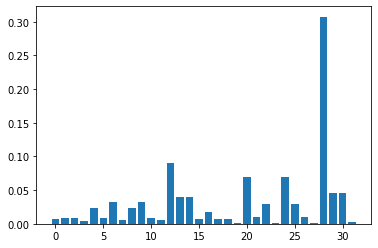

In [124]:
@qml.qnode(dev)
def test_circuit():
    ansatz(res)
    return qml.probs(wires=dev.wires)

probs = test_circuit()
plt.bar(range(2**len(dev.wires)), probs)

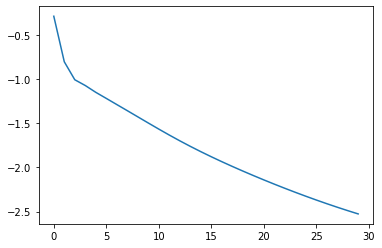

In [127]:
plt.plot(range(30), res_energies)

### QAOA Seeded By FALQON

<center>
    <img src="falqon/falqon.png" style="width:800px;">
</center>

So far, we have described the theory behind FALQON, and implemented a basic example for the MaxClique problem. As was mentioned multiple times through this tutorial, and as you probably noticed yourself, FALQON looks an awful lot like QAOA.

In the following section we will compare QAOA and QAOA seeded by FALQON.